<a href="https://colab.research.google.com/github/leobonn1/devai/blob/main/brazilian_court_decisions_binary_vectorizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install datasets
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.4 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

dataset = load_dataset('joelniklaus/brazilian_court_decisions')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [3]:
train_texts = dataset['train']['decision_description']
train_labels = dataset['train']['judgment_label']

test_texts = dataset['test']['decision_description']
test_labels= dataset['test']['judgment_label']

print(f'\nTrain size: {len(train_texts)} -- {len(train_labels)}')
print(f'Test size: {len(test_texts)} -- {len(test_labels)}')



Train size: 3234 -- 3234
Test size: 405 -- 405


In [4]:
from collections import Counter

print(f'Train Labels Distribution: {Counter(train_labels)}')
print(f'Test Labels Distribution: {Counter(test_labels)}')

Train Labels Distribution: Counter({'no': 1960, 'partial': 677, 'yes': 597})
Test Labels Distribution: Counter({'no': 234, 'partial': 93, 'yes': 78})


In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_encoder.fit(train_labels)

train_labels = label_encoder.transform(train_labels)
test_labels = label_encoder.transform(test_labels)

print(f'Train Labels Distribution: {Counter(train_labels)}')
print(f'Test Labels Distribution: {Counter(test_labels)}')

Train Labels Distribution: Counter({0: 1960, 1: 677, 2: 597})
Test Labels Distribution: Counter({0: 234, 1: 93, 2: 78})


In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_encoder.fit(train_labels)

train_labels = label_encoder.transform(train_labels)
test_labels = label_encoder.transform(test_labels)

print(f'Train Labels Distribution: {Counter(train_labels)}')
print(f'Test Labels Distribution: {Counter(test_labels)}')

Train Labels Distribution: Counter({0: 1960, 1: 677, 2: 597})
Test Labels Distribution: Counter({0: 234, 1: 93, 2: 78})


In [7]:
!python -m spacy download pt_core_news_sm

import spacy

from tqdm import tqdm

def preprocess_texts(list_texts):
  nlp = spacy.load('pt_core_news_sm', disable=['ner'])
  new_texts = []
  with tqdm(total=len(list_texts), desc='Preprocessing') as pbar:
    for text in list_texts:
      doc = nlp(text)
      tokens = [t.lemma_.lower() for t in doc if t.pos_ != 'PUNCT' and not t.is_stop]
      texto_normalizado = ' '.join(tokens)
      new_texts.append(texto_normalizado)
      pbar.update(1)
  return new_texts

train_texts = preprocess_texts(train_texts)

test_texts = preprocess_texts(test_texts)

2023-12-11 19:09:02.036370: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-11 19:09:02.036467: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-11 19:09:02.036516: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 19:09:02.057668: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 19:09:05.014116: W tensorflow/compiler/

Preprocessing: 100%|██████████| 405/405 [00:07<00:00, 57.49it/s]


In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer_option = 'binary'
# vectorizer_option = 'count'
# vectorizer_option = 'tf_idf'

vectorizer = None

if vectorizer_option == 'binary':
  vectorizer = CountVectorizer(binary=True, max_features=None, ngram_range=(1, 1))
elif vectorizer_option == 'count':
  vectorizer = CountVectorizer(binary=False, max_features=None, ngram_range=(1, 1))
elif vectorizer_option == 'tf_idf':
  vectorizer = TfidfVectorizer()

print(f'Vectorizer Option: {vectorizer_option}')

Vectorizer Option: binary


In [9]:
X_train = vectorizer.fit_transform(train_texts).toarray()
X_test = vectorizer.transform(test_texts).toarray()

print(f'\nExample Raw Text: {train_texts[0]}')
print(f'\nExample Vectorized Text: {X_train[0]}')
print(f'Vocabulary: {len(vectorizer.vocabulary_)}')


Example Raw Text: direito penal processual penal revisão criminal artigo 621 código processo penal requerente condenado júri popular prática crimes homicídio duplamente qualificado homicídio qualificado tentado pleito refazimento dosimetria pena imposta requerente admissibilidade via revisional precedentes alegação erro processo dosimetria pena comportamento vítima circunstância judicial neutra considerada desfavorável sentenciando precedentes superior tribunal justiça entendimento câmara criminal tribunal justiça afastamento culpabilidade ausência exposição motivos incremento pena-base afastado desvalor valoração atribuída circunstâncias crime mantida fundamentação idônea pena-base reduzida compensação agravante motivação torpe atenuante confissão espontânea pena privativa liberdade redimensionada crime tentado aplicada fração redutora máxima ante distância atos praticados requerente consumação crime pena redimensionada

Example Vectorized Text: [0 0 0 ... 0 0 0]
Vocabulary: 12447


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier
import lightgbm as ltb
from sklearn.neural_network import MLPClassifier
from sklearn import svm

classifiers = {
    'Logistic_Regression': LogisticRegression(class_weight='balanced',
                                              max_iter=1000),
    'Multinomial_NB': MultinomialNB(),
    'KNN': KNeighborsClassifier(),
    'Random_Forest': RandomForestClassifier(),
    'Decision_Tree' : DecisionTreeClassifier(),
    'Extra_Tree' : ExtraTreesClassifier(),
    'Cat_Boost' : CatBoostClassifier(iterations=1000),
    'Light_GBM' : ltb.LGBMClassifier(),
    'MLP' :  MLPClassifier(random_state=1, max_iter=300),
    'SVM' : svm.SVC()
}

***********************************************

Classifier: Logistic_Regression
              precision    recall  f1-score     support
0              0.804167  0.824786  0.814346  234.000000
1              0.655914  0.655914  0.655914   93.000000
2              0.625000  0.576923  0.600000   78.000000
accuracy       0.738272  0.738272  0.738272    0.738272
macro avg      0.695027  0.685874  0.690087  405.000000
weighted avg   0.735617  0.738272  0.736684  405.000000


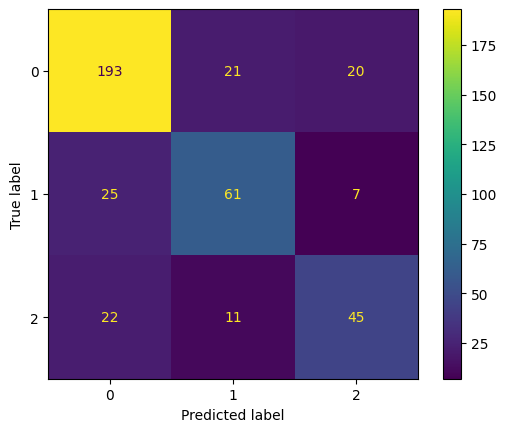

***********************************************

Classifier: Multinomial_NB
              precision    recall  f1-score    support
0              0.788660  0.653846  0.714953  234.00000
1              0.478992  0.612903  0.537736   93.00000
2              0.478261  0.564103  0.517647   78.00000
accuracy       0.627160  0.627160  0.627160    0.62716
macro avg      0.581971  0.610284  0.590112  405.00000
weighted avg   0.657770  0.627160  0.636259  405.00000


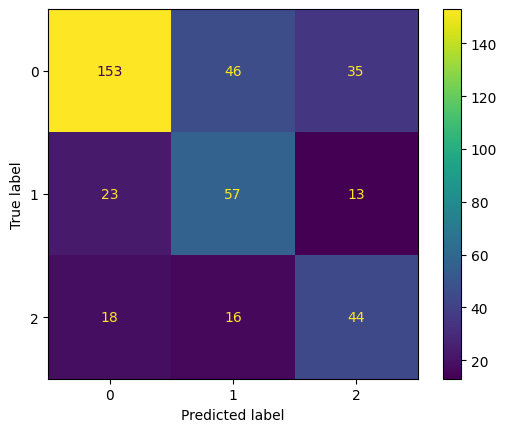

***********************************************

Classifier: KNN
              precision    recall  f1-score     support
0              0.696667  0.893162  0.782772  234.000000
1              0.720930  0.333333  0.455882   93.000000
2              0.532258  0.423077  0.471429   78.000000
accuracy       0.674074  0.674074  0.674074    0.674074
macro avg      0.649952  0.549858  0.570027  405.000000
weighted avg   0.670574  0.674074  0.647746  405.000000


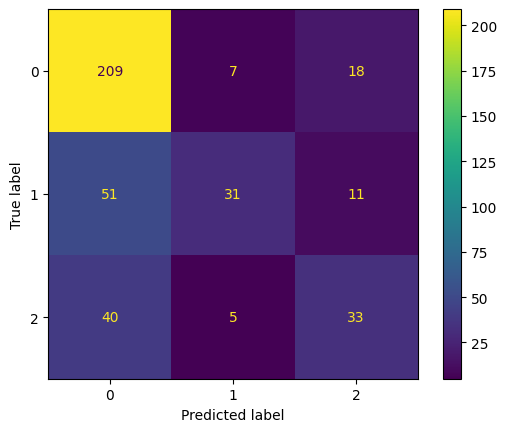

***********************************************

Classifier: Random_Forest
              precision    recall  f1-score     support
0              0.723473  0.961538  0.825688  234.000000
1              0.800000  0.473118  0.594595   93.000000
2              0.794872  0.397436  0.529915   78.000000
accuracy       0.740741  0.740741  0.740741    0.740741
macro avg      0.772781  0.610698  0.650066  405.000000
weighted avg   0.754797  0.740741  0.715658  405.000000


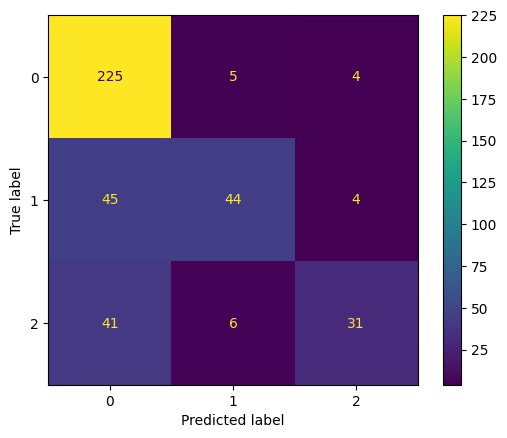

***********************************************

Classifier: Decision_Tree
              precision    recall  f1-score     support
0              0.772727  0.799145  0.785714  234.000000
1              0.581395  0.537634  0.558659   93.000000
2              0.571429  0.564103  0.567742   78.000000
accuracy       0.693827  0.693827  0.693827    0.693827
macro avg      0.641850  0.633627  0.637372  405.000000
weighted avg   0.690023  0.693827  0.691596  405.000000


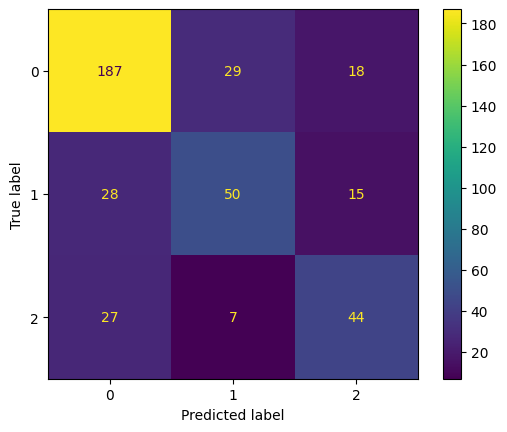

***********************************************

Classifier: Extra_Tree
              precision    recall  f1-score     support
0              0.722581  0.957265  0.823529  234.000000
1              0.785714  0.473118  0.590604   93.000000
2              0.794872  0.397436  0.529915   78.000000
accuracy       0.738272  0.738272  0.738272    0.738272
macro avg      0.767722  0.609273  0.648016  405.000000
weighted avg   0.751001  0.738272  0.713495  405.000000


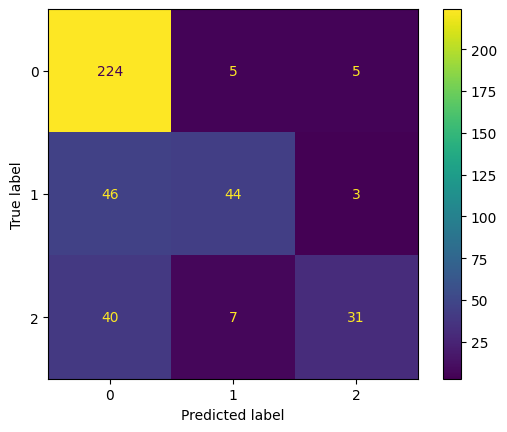

***********************************************

Classifier: Cat_Boost
Learning rate set to 0.084008
0:	learn: 1.0515636	total: 199ms	remaining: 3m 18s
1:	learn: 1.0155812	total: 324ms	remaining: 2m 41s
2:	learn: 0.9885177	total: 444ms	remaining: 2m 27s
3:	learn: 0.9603205	total: 556ms	remaining: 2m 18s
4:	learn: 0.9376923	total: 675ms	remaining: 2m 14s
5:	learn: 0.9202853	total: 787ms	remaining: 2m 10s
6:	learn: 0.9058579	total: 918ms	remaining: 2m 10s
7:	learn: 0.8888309	total: 1.03s	remaining: 2m 8s
8:	learn: 0.8762124	total: 1.15s	remaining: 2m 7s
9:	learn: 0.8662816	total: 1.27s	remaining: 2m 5s
10:	learn: 0.8556068	total: 1.39s	remaining: 2m 4s
11:	learn: 0.8441237	total: 1.5s	remaining: 2m 3s
12:	learn: 0.8370872	total: 1.62s	remaining: 2m 2s
13:	learn: 0.8290257	total: 1.73s	remaining: 2m 1s
14:	learn: 0.8199340	total: 1.85s	remaining: 2m 1s
15:	learn: 0.8117023	total: 1.98s	remaining: 2m 1s
16:	learn: 0.8034754	total: 2.12s	remaining: 2m 2s
17:	learn: 0.7953455	total: 2.24s	re

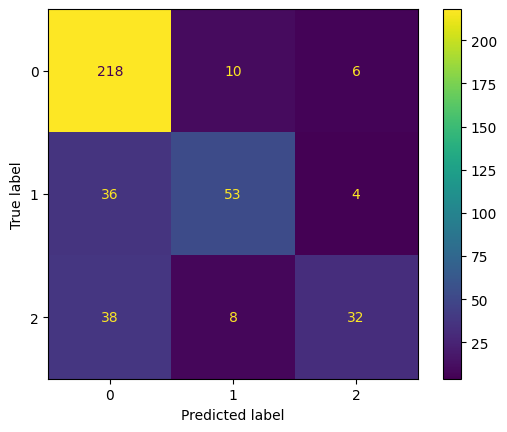

***********************************************

Classifier: Light_GBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3484
[LightGBM] [Info] Number of data points in the train set: 3234, number of used features: 1742
[LightGBM] [Info] Start training from score -0.500775
[LightGBM] [Info] Start training from score -1.563804
[LightGBM] [Info] Start training from score -1.689558
              precision    recall  f1-score     support
0              0.826255  0.914530  0.868154  234.000000
1              0.725000  0.623656  0.670520   93.000000
2              0.727273  0.615385  0.666667   78.000000
accuracy       0.790123  0.790123  0.790123    0.790123
macro avg      0.759509  0.717857  0.735114  405.000000
weighted avg   0.783940  0.790123  0.783967  405.000000


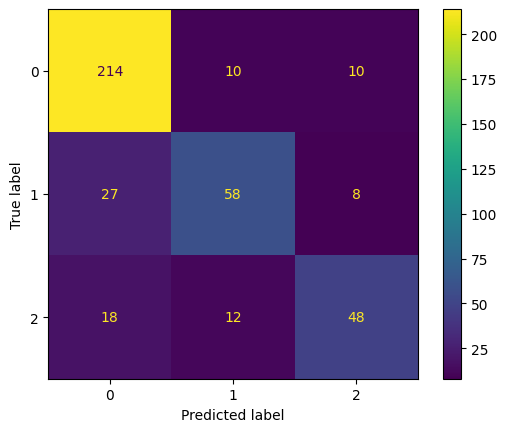

***********************************************

Classifier: MLP
              precision    recall  f1-score     support
0              0.789272  0.880342  0.832323  234.000000
1              0.678161  0.634409  0.655556   93.000000
2              0.614035  0.448718  0.518519   78.000000
accuracy       0.740741  0.740741  0.740741    0.740741
macro avg      0.693823  0.654489  0.668799  405.000000
weighted avg   0.730008  0.740741  0.731296  405.000000


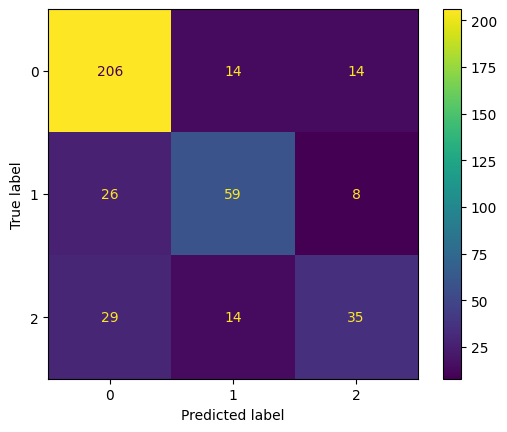

***********************************************

Classifier: SVM
              precision    recall  f1-score     support
0              0.714744  0.952991  0.816850  234.000000
1              0.781818  0.462366  0.581081   93.000000
2              0.789474  0.384615  0.517241   78.000000
accuracy       0.730864  0.730864  0.730864    0.730864
macro avg      0.762012  0.599991  0.638391  405.000000
weighted avg   0.744538  0.730864  0.705008  405.000000


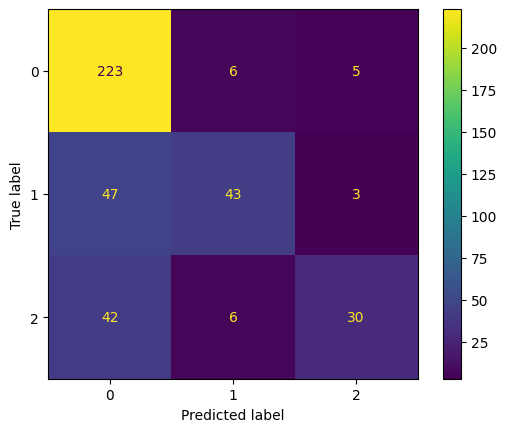

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

for classifier_name, classifier in classifiers.items():
  print('***********************************************')
  print(f'\nClassifier: {classifier_name}')

  classifier.fit(X_train, train_labels)

  y_pred = classifier.predict(X_test)

  report = classification_report(test_labels, y_pred, output_dict=True)
  df = pd.DataFrame(report).transpose()
  df.to_csv(f'{vectorizer_option}_{classifier_name}.csv')
  print(df)

  ConfusionMatrixDisplay.from_predictions(test_labels, y_pred)

  plt.show()
